# Diputado Distrito

#### Imports

In [1]:
import time
import subprocess
import math
from pathlib import Path
import warnings
                                                                                                            
from tqdm.notebook import tqdm

import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
import psycopg2 as psql
from sqlalchemy import create_engine
from functools import partial
import matplotlib.pyplot as plt

from networkx import is_connected, connected_components
from gerrychain import (
    Graph, updaters, Partition, constraints, MarkovChain, accept, proposals,
    tree, random
)

### Config

In [3]:
# When being run in collab please set to False
query_postgres = False

# Define seed
seed = 42

# Province to study
province_id = '30'


# GerryChain parameters

# Wanted district size in population
target = 33000

# Variable which we are using to create district over target value
variable = "pob_t_total"

# Parameter for spanning tree method, set to 2 is fine
node_repeats = 2

# Epson tolerance for map to initialize
init_epsilon = 0.285

# Error tolerance for districts
epsilon = 0.2

# Percentage difference between populations mac vs low
partition_percentage = 0.45

# Maximum number of possible values
total_steps =  56

# From the total_steps obtain the top maps that minimize the population best
top_iteration = 10

In [2]:
# When being run in collab please set to False
query_postgres = None # True

# Define seed
seed = None # 42

# Province to study
province_id = '' # '30'


# GerryChain parameters

# Wanted district size in population
target = None # 33000

# Variable which we are using to create district over target value
variable = "" # "pob_t_total"

# Parameter for spanning tree method, set to 2 is fine
node_repeats = None # 2

# Epson tolerance for map to initialize
init_epsilon = None # 0.285

# Error tolerance for districts
epsilon = None # 0.2

# Percentage difference between populations mac vs low
partition_percentage = None

# Maximum number of possible values
total_steps =  None # 56

# From the total_steps obtain the top maps that minimize the population best
top_iteration = None # 10


In [4]:
# reproducibility
random.random.seed(seed)

In [5]:
# base path
base_path = Path().absolute()

# Uncomment when using a specific notebook of province
# base_path = base_path.parent

# Create data folder for each province
subprocess.call(['mkdir', '-p', base_path.joinpath(f'data/{province_id}')])

# Create a map folder for each province
subprocess.call(['mkdir', '-p', base_path.joinpath(f'maps/{province_id}')])

0

In [6]:
psql_config = {
    'database': '',
    'user': '',
    'password': '',
    'host': '',
    'port': ''
}


if query_postgres:
    conn = psql.connect(**psql_config)

In [7]:
query = f"""

"""

if query_postgres:
    province = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    province = gpd.read_parquet(base_path.joinpath('data', province_id, 'province.parquet'))

province.head()

,id_area,name,pob_t_total,geometry
0,30,Murcia,1493898.0,"MULTIPOLYGON (((-1.54669 37.40733, -1.54845 37..."


In [8]:
if query_postgres:
    province.to_parquet(base_path.joinpath('data', province_id, 'province.parquet'))

In [9]:
query = f"""

"""

if query_postgres:
    municipality = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    municipality = gpd.read_parquet(base_path.joinpath('data', province_id, 'municipality.parquet'))

municipality.head()

,id_area,name,pob_t_total,geometry
0,30021,Fuente Álamo de Murcia,16583.0,"MULTIPOLYGON (((-1.17607 37.65952, -1.17662 37..."
1,30019,Cieza,34988.0,"MULTIPOLYGON (((-1.31888 38.31345, -1.31911 38..."
2,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37..."
3,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38..."
4,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38..."


In [10]:
if query_postgres:
    municipality.to_parquet(base_path.joinpath('data', province_id, 'municipality.parquet'))

In [11]:
query = f"""

"""

if query_postgres:
    district = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    district = gpd.read_parquet(base_path.joinpath('data', province_id, 'district.parquet'))

district.head()

,id_area,name,pob_t_total,geometry
0,3090201,3090201,16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85195 37..."
1,3090101,3090101,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38..."
2,3004301,3004301,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11950 38..."
3,3004201,3004201,2910.0,"MULTIPOLYGON (((-1.31083 38.12816, -1.31010 38..."
4,3004106,3004106,997.0,"MULTIPOLYGON (((-0.87233 37.60224, -0.84062 37..."


In [12]:
if query_postgres:
    district.to_parquet(base_path.joinpath('data', province_id, 'district.parquet'))

In [13]:
query = f"""

"""

if query_postgres:
    zip_code = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    zip_code = gpd.read_parquet(base_path.joinpath('data', province_id, 'zip_code.parquet'))

zip_code.head()

,id_area,name,pob_t_total,geometry
0,30001,30001,6672.558439,"MULTIPOLYGON (((-1.12543 37.98749, -1.12644 37..."
1,30002,30002,20612.835950,"MULTIPOLYGON (((-1.12798 37.98225, -1.12794 37..."
2,30009,30009,51048.864231,"MULTIPOLYGON (((-1.16049 37.99899, -1.16046 37..."
3,30005,30005,8933.290422,"MULTIPOLYGON (((-1.13518 37.98922, -1.13513 37..."
4,30003,30003,11593.958973,"MULTIPOLYGON (((-1.12372 37.98900, -1.12363 37..."


In [14]:
if query_postgres:
    zip_code.to_parquet(base_path.joinpath('data', province_id, 'zip_code.parquet'))

In [15]:
query = f"""

"""


if query_postgres:
    census_section = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    census_section = gpd.read_parquet(base_path.joinpath('data', province_id, 'census_section.parquet'))
    
census_section.head()

,id_area,name,pob_t_total,geometry
0,3090101002,3090101002,1528.0,"MULTIPOLYGON (((-1.04729 38.06279, -1.04704 38..."
1,3003401001,3003401001,1264.0,"MULTIPOLYGON (((-1.46975 38.19402, -1.46960 38..."
2,3003003045,3003003045,855.0,"MULTIPOLYGON (((-1.12760 37.97707, -1.12758 37..."
3,3001501020,3001501020,1142.0,"MULTIPOLYGON (((-1.85853 38.10228, -1.85954 38..."
4,3090101008,3090101008,1052.0,"MULTIPOLYGON (((-1.04986 38.06294, -1.05229 38..."


In [16]:
if query_postgres:
    census_section.to_parquet(base_path.joinpath('data', province_id, 'census_section.parquet'))

## Find optimal aggregation

In [17]:
# Obtain province codes
province['province_id'] = province['id_area']
province_ids = province['province_id'].tolist()

municipality['province_id'] = municipality['id_area'].str[:2]
# municipality['latitude'] = municipality['geometry'].centroid.y
# municipality['longitude'] = municipality['geometry'].centroid.x

district['province_id'] = district['id_area'].str[:2]
# district['latitude'] = district['geometry'].centroid.y
# district['longitude'] = district['geometry'].centroid.x

zip_code['province_id'] = zip_code['id_area'].str[:2]
# zip_code['latitude'] = zip_code['geometry'].centroid.y
# zip_code['longitude'] = zip_code['geometry'].centroid.x

census_section['province_id'] = census_section['id_area'].str[:2]
census_section['municipality_id'] = census_section['id_area'].str[:5]
# census_section['latitude'] = census_section['geometry'].centroid.y
# census_section['longitude'] = census_section['geometry'].centroid.x

In [18]:
query = f"province_id == '{province_id}'"

In [19]:
province_cp = province.query(query).copy()
municipality_cp = municipality.query(query).copy()
district_cp = district.query(query).copy()
zip_code_cp = zip_code.query(query).copy()
census_section_cp = census_section.query(query).copy()

geo_data = {
    'province': province_cp, 
    'municipality': municipality_cp,
    'district': district_cp,
    'zip_code': zip_code_cp,
    'census_section': census_section_cp
}

KeplerGl(height=800, width=1000).save_to_html(
    geo_data, file_name=base_path.joinpath('maps', province_id, 'province.html'), center_map=True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to /home/iplaton/myprojects/diputado-distrito/maps/30/province.html!


In [20]:
print(census_section.shape)
census_section.head()

(1226, 6)


,id_area,name,pob_t_total,geometry,province_id,municipality_id
0,3090101002,3090101002,1528.0,"MULTIPOLYGON (((-1.04729 38.06279, -1.04704 38...",30,30901
1,3003401001,3003401001,1264.0,"MULTIPOLYGON (((-1.46975 38.19402, -1.46960 38...",30,30034
2,3003003045,3003003045,855.0,"MULTIPOLYGON (((-1.12760 37.97707, -1.12758 37...",30,30030
3,3001501020,3001501020,1142.0,"MULTIPOLYGON (((-1.85853 38.10228, -1.85954 38...",30,30015
4,3090101008,3090101008,1052.0,"MULTIPOLYGON (((-1.04986 38.06294, -1.05229 38...",30,30901


In [21]:
municipality_agg = census_section.dissolve(by='municipality_id', aggfunc='sum').reset_index()
print(municipality_agg.shape)
municipality_agg.head()

(45, 3)


,municipality_id,geometry,pob_t_total
0,30001,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",6127.0
1,30002,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",12964.0
2,30003,"MULTIPOLYGON (((-1.59163 37.40163, -1.59185 37...",35301.0
3,30004,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",1373.0
4,30005,"POLYGON ((-1.20478 37.95938, -1.20457 37.95891...",42048.0


In [22]:
mask = municipality_agg[variable] < target

gdf_area = municipality_agg[mask].copy()

# Feature eng for concat
gdf_area = gdf_area.rename(columns = {'municipality_id': 'id_area'})
gdf_area.head()

,id_area,geometry,pob_t_total
0,30001,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",6127.0
1,30002,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",12964.0
3,30004,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",1373.0
5,30006,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476...",1022.0
6,30007,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928...",9638.0


In [23]:
# Municipalities with more than target population
filtered_out = municipality_agg[~mask].copy()
filtered_out.head()

,municipality_id,geometry,pob_t_total
2,30003,"MULTIPOLYGON (((-1.59163 37.40163, -1.59185 37...",35301.0
4,30005,"POLYGON ((-1.20478 37.95938, -1.20457 37.95891...",42048.0
15,30016,"POLYGON ((-0.87201 37.58752, -0.87199 37.58598...",214802.0
18,30019,"POLYGON ((-1.31888 38.31345, -1.31893 38.31329...",34988.0
23,30024,"POLYGON ((-1.64745 37.52725, -1.64766 37.52683...",94404.0


<AxesSubplot:>

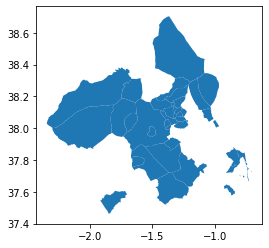

In [24]:
gdf_area.plot()

<AxesSubplot:>

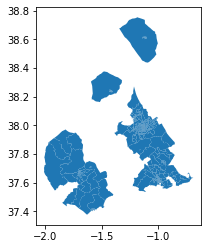

In [25]:
filtered_census_section = filtered_out['municipality_id'].tolist()
difference = census_section[census_section['municipality_id'].isin(filtered_census_section)]

# Feature eng for concat
difference = difference.drop(['name', 'province_id', 'municipality_id'], axis=1)

# Filter out from zip_code
#Graph.from_geodataframe(difference)
if difference.shape[0]!=0:
    difference.plot()

(875, 3)


<AxesSubplot:>

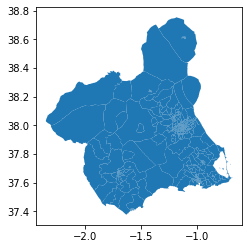

In [26]:
cols = difference.columns

gdf = gpd.GeoDataFrame(pd.concat([gdf_area[cols], difference], ignore_index=True))
print(gdf.shape)
gdf.plot()

In [27]:
gdf.head()

,id_area,pob_t_total,geometry
0,30001,6127.0,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614..."
1,30002,12964.0,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330..."
2,30004,1373.0,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741..."
3,30006,1022.0,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476..."
4,30007,9638.0,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928..."


In [28]:
gdf.tail()

,id_area,pob_t_total,geometry
870,3003001049,967.0,"MULTIPOLYGON (((-1.14468 38.00633, -1.14468 38..."
871,3003006015,1052.0,"MULTIPOLYGON (((-1.04928 37.97948, -1.05018 37..."
872,3003002015,1166.0,"MULTIPOLYGON (((-1.12164 37.99091, -1.12164 37..."
873,3001609004,1286.0,"MULTIPOLYGON (((-1.04362 37.62911, -1.04359 37..."
874,3002401044,1546.0,"MULTIPOLYGON (((-1.68422 37.68262, -1.68408 37..."


In [29]:
graph = Graph.from_geodataframe(gdf)
graph.add_data(gdf)

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/gerrychain/graph/graph.py:152: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [30]:
myupdaters = {
    "population": updaters.Tally(variable, alias="population"),
    "cut_edges": updaters.cut_edges,
}

45.26963636363636


<AxesSubplot:>

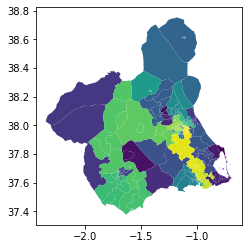

In [31]:
total_population = sum([graph.nodes[n][variable] for n in graph.nodes])
districts = total_population / target
print(districts)

assignment = tree.recursive_tree_part(
    graph, 
    range(int(round(districts))),
    target, #ideal population for a district
    variable,
    init_epsilon
)

#make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)
initial_partition.plot(gdf) #you have to hand it gdf, the geodataframe for the graph

In [32]:
mapper = {graph.nodes[node]['id_area']: node for node in graph.nodes}
gdf['district'] = gdf['id_area'].apply(lambda x: assignment.get(mapper.get(x)))
display(gdf.groupby('district')[variable].sum().describe())
gdf.head()

count       45.000000
mean     33197.733333
std       4499.404938
min      24272.000000
25%      31294.000000
50%      32767.000000
75%      34724.000000
max      47881.000000
Name: pob_t_total, dtype: float64

,id_area,pob_t_total,geometry,district
0,30001,6127.0,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",15
1,30002,12964.0,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",13
2,30004,1373.0,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",13
3,30006,1022.0,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476...",2
4,30007,9638.0,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928...",5


In [33]:
gdf.shape

(875, 4)

In [34]:
districts = gdf.dissolve(by='district', aggfunc='sum').reset_index().copy()

In [35]:
kepler = KeplerGl(height=800, width=1000)

municipality_agg_cp = municipality_agg.copy()
kepler.add_data(data=municipality_agg_cp, name='municipality')

districts_cp = districts.copy()
kepler.add_data(data=districts_cp, name='district')

gdf_cp = gdf.copy()
kepler.add_data(data=gdf_cp, name='municipalites-censussection')


kepler.save_to_html(file_name=base_path.joinpath('maps', province_id, 'initialized-map.html'))

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to /home/iplaton/myprojects/diputado-distrito/maps/30/initialized-map.html!


In [36]:
#no need for contiguity since that is forced by the proposal
myconstraints = [
    constraints.contiguous, #fast contiguity tracker only for flip walks
    constraints.contiguous_bfs,
    constraints.within_percent_of_ideal_population(initial_partition, percent=partition_percentage) #population deviation
]

#little python trick to fix some parameters in the proposal function
myproposal = partial(
    proposals.recom,
    pop_col=variable,
    pop_target=target,
    epsilon=epsilon, #population tolerance
    node_repeats=node_repeats #parameter for spanning tree method, set to 2 is fine
)

In [37]:
# Configure the MarkovChain.
chain = MarkovChain(
    proposal=myproposal,
    constraints=myconstraints,
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=total_steps
)

In [38]:
try:
    for i, step in enumerate(chain, 1):
        print(i, end=" ")
        gdf['flipstep{}'.format(i)] = [step.assignment[n] for n in graph.nodes] #store plan
except:
    warnings.warn('Flipsteps did not complete succesfully')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 

In [39]:
# Obtain all possible iterations
iterations = [col for col in gdf if 'flipstep' in col]

iteration_gdfs = {}
residuals = {}
for column in iterations:
    # Store geopandas dataframe for each iteration
    districts = gdf.dissolve(by=column, aggfunc='sum').reset_index()
    iteration_gdfs[column] = districts

    # Obtain and store residuals for each case
    districts['target_pob'] = target
    districts['residuals'] = (districts['target_pob'] - districts['pob_t_total']).abs()
    residuals[column] = (districts['residuals'].sum(), districts['residuals'].std())

In [40]:
flip_step_order = {k: v for k, v in sorted(residuals.items(), key=lambda item: item[1][0])}
flip_step_order

{'flipstep0': (140731.99999999983, 3206.5333614208876),
 'flipstep1': (148411.99999999983, 3276.344630422612),
 'flipstep2': (150523.7185929647, 3235.937637245907),
 'flipstep3': (152831.71859296475, 3311.9992998691814),
 'flipstep4': (164489.99999999988, 3610.2997961494407),
 'flipstep9': (164895.7185929648, 3580.6498766888035),
 'flipstep7': (165887.7185929648, 3577.883435492657),
 'flipstep8': (165887.7185929648, 3591.8942667382735),
 'flipstep10': (171827.99999999994, 3718.8617486053136),
 'flipstep14': (175893.99999999994, 3625.973350644378),
 'flipstep15': (175893.99999999994, 3625.973350644378),
 'flipstep16': (175893.99999999994, 3622.49970368799),
 'flipstep11': (177209.99999999994, 3757.2386446049054),
 'flipstep12': (177209.99999999994, 3751.5056317750314),
 'flipstep13': (177209.99999999994, 3754.2321277294695),
 'flipstep5': (177545.99999999994, 3868.772099056796),
 'flipstep6': (177545.99999999994, 3849.2213214769886),
 'flipstep19': (178451.71859296464, 3672.925239347224

In [41]:
province_cp = province.copy()
municipality_cp = municipality.copy()
zip_code_cp = zip_code.copy()
census_section_cp = census_section.copy()
gdf_cp = gdf.copy()


geo_data = {
    'province': province_cp, 
    'municipality': municipality_cp,
    'zip_code': zip_code_cp,
    'census_section': census_section_cp,
    'municipalites-censussection': gdf_cp
}

to_json = {}
for n, order in enumerate(list(flip_step_order.keys())[:top_iteration]):
    
    map_df = iteration_gdfs[order].copy()
    geo_data[f'iteration_{n}'] = map_df
    
    json_df = iteration_gdfs[order].copy()
    to_json[f'iteration_{n}'] = json_df

# Create maps
KeplerGl(height=800, width=1000).save_to_html(
    geo_data, 
    file_name=base_path.joinpath('maps', province_id, f'districts-ordered-iterations-top-{top_iteration}.html'),
    center_map=True
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to /home/iplaton/myprojects/diputado-distrito/maps/30/districts-ordered-iterations-top-10.html!


In [42]:

# Iteration number selected to transform to GeoJson
# iteration_num = 40

# to_json[f'iteration_{n}'].to_file(f'districts-selected-iteration-{iteration_num}.json', driver='GeoJSON')